# Baseline Model Development

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import statsmodels.api as sm


%matplotlib inline

In [205]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens')
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [210]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,first_year_elected,election_year,tenure,age,is_sponsor,sponsor_party_is_lead,cosponsor_party_D_%,cosponsor_party_R_%,percent_cosponsors_lead_party,sponsor_is_same_party
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1978,0,35,76,0,1,0.5,0.5,0.5,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1978,0,35,72,0,1,0.5,0.5,0.5,1
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1980,0,33,80,0,1,0.5,0.5,0.5,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1984,0,29,74,0,1,0.5,0.5,0.5,1
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1980,0,33,73,0,1,0.5,0.5,0.5,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110268 entries, 5 to 306260
Data columns (total 67 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       110268 non-null  int64  
 1   chamber                        110268 non-null  object 
 2   rollnumber                     110268 non-null  int64  
 3   icpsr                          110268 non-null  int64  
 4   cast_code                      110268 non-null  int64  
 5   state_abbrev                   110268 non-null  object 
 6   bioname                        110268 non-null  object 
 7   bioguide_id                    110268 non-null  object 
 8   born                           110268 non-null  int64  
 9   nominate_dim1                  110268 non-null  float64
 10  nominate_dim2                  110268 non-null  float64
 11  party                          110268 non-null  object 
 12  last_name                     

None

In [211]:
def find_cosponsor_of_my_party(senator):
    if senator['party'] == 'D':
        return senator['cosponsors_D']
    if senator['party'] == 'R':
        return senator['cosponsors_R']
    if senator['party'] == 'I':
        return senator['cosponsors_ID']

In [212]:
#drop any cast codes that are present or absent, and change cast code 6 ('nay') to 0
main_df.drop(main_df[~main_df['cast_code'].isin([1,6])].index, inplace=True)
main_df['cast_code'] = main_df['cast_code'].apply(lambda x: 0 if x == 6 else 1)

#drop anywhere df lacks sponsor info
main_df.dropna(subset=['sponsor'], inplace=True)

#dummy variable lead party designation
main_df['lead_party_D'] = main_df['lead_party'].apply(lambda x: 1 if x == 'D' else 0)

#make interaction of party with cosponsors of that party
main_df['cosponsor_my_party'] = main_df.apply(lambda x: find_cosponsor_of_my_party(x), axis=1)

#exponentiate cosponsor values
for i in ['cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID', 'cosponsor_my_party']:
    main_df[i+'^2'] = main_df[i]**2
    
#dummy variable party and sponsor_party columns
for party in ['D', 'R']:
    main_df['party_'+party] = main_df['party'].apply(lambda x: 1 if x == party else 0)
    main_df['sponsor_party_'+party] = main_df['sponsor_party'].apply(lambda x: 1 if x == party else 0)


display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsor_my_party,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,4.0,1,1,0,1,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,4.0,1,1,0,1,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,4.0,1,1,0,1,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,4.0,1,1,0,1,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,4.0,1,1,0,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100166 entries, 5 to 306260
Data columns (total 78 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       100166 non-null  int64  
 1   chamber                        100166 non-null  object 
 2   rollnumber                     100166 non-null  int64  
 3   icpsr                          100166 non-null  int64  
 4   cast_code                      100166 non-null  int64  
 5   state_abbrev                   100166 non-null  object 
 6   bioname                        100166 non-null  object 
 7   bioguide_id                    100166 non-null  object 
 8   born                           100166 non-null  int64  
 9   nominate_dim1                  100166 non-null  float64
 10  nominate_dim2                  100166 non-null  float64
 11  party                          100166 non-null  object 
 12  last_name                     

None

In [237]:
dep_col = 'cast_code'

senator_info = ['nominate_dim1', 'nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 
                'age', 'is_sponsor', 'sponsor_is_same_party', 'party_D', 'party_R', 'cosponsor_my_party', 
                'cosponsor_my_party^2']

bill_info = ['sponsor_party_is_lead', 'cosponsor_party_D_%', 'cosponsor_party_R_%', 
             'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R',
             'cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID',
             'cosponsors^2', 'cosponsors_D^2', 'cosponsors_R^2', 'cosponsors_ID^2']

indep_cols = senator_info + bill_info

In [335]:
scalar = StandardScaler()

In [336]:
y = main_df[dep_col]
X = main_df[indep_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [337]:
logreg = LogisticRegression()
rfe = RFE(logreg, 15)
rfe = rfe.fit(X_train_df, y_train.values)

print(rfe.ranking_)

low_rank_features = []
for i in range(len(X.columns)):
    if rfe.ranking_[i] != 1:
        low_rank_features.append(X.columns[i])
        
print('Low ranked features: ', low_rank_features)

[ 1  3  6  1  8  9 13  1  4  5  1  1  1  1  1  1  1  1  1  1  7  1 11  2
 12  1 10]
Low ranked features:  ['nominate_dim2', 'percent_campaign_vote', 'tenure', 'age', 'is_sponsor', 'party_D', 'party_R', 'cosponsors_D', 'cosponsors_ID', 'cosponsors^2', 'cosponsors_D^2', 'cosponsors_ID^2']


In [338]:
cols_to_drop = low_rank_features

new_indep_cols = [x for x in indep_cols if x not in cols_to_drop]

X = main_df[new_indep_cols]
y = main_df[dep_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [339]:
logit_model=sm.Logit(y_train, X_train_df)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.678317
         Iterations 5
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     -0.031    
Dependent Variable:      cast_code            AIC:                  95151.7517
Date:                    2020-05-26 18:23     BIC:                  95289.1203
No. Observations:        70116                Log-Likelihood:       -47561.   
Df Model:                14                   LL-Null:              -46136.   
Df Residuals:            70101                LLR p-value:          1.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          5.0000                                               
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------

In [340]:
low_p_val_cols = []

X = main_df[[x for x in new_indep_cols if x not in low_p_val_cols]]
y = main_df[dep_col]

scalar = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [341]:
logit_model=sm.Logit(y_train, X_train_df)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.678317
         Iterations 5
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     -0.031    
Dependent Variable:      cast_code            AIC:                  95151.7517
Date:                    2020-05-26 18:23     BIC:                  95289.1203
No. Observations:        70116                Log-Likelihood:       -47561.   
Df Model:                14                   LL-Null:              -46136.   
Df Residuals:            70101                LLR p-value:          1.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          5.0000                                               
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------

In [342]:
logreg = LogisticRegression()
logreg.fit(X_train_df, y_train)
y_pred = logreg.predict(X_test_df)

[[ 1205  9767]
 [ 1275 17803]]
              precision    recall  f1-score   support

           0       0.49      0.11      0.18     10972
           1       0.65      0.93      0.76     19078

    accuracy                           0.63     30050
   macro avg       0.57      0.52      0.47     30050
weighted avg       0.59      0.63      0.55     30050

Accuracy score: 0.6325


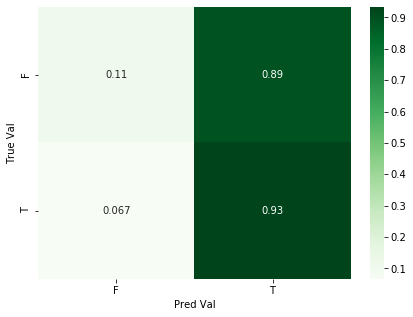

In [343]:
confusion_reporting(y_test, y_pred)

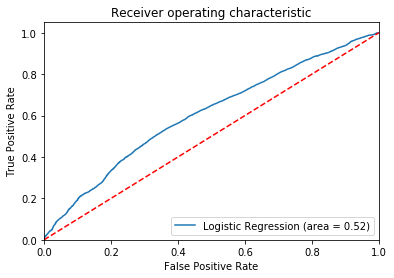

In [344]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_df))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_df)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Random Forest

In [352]:
rf_clf = RandomForestClassifier()

In [353]:
scalar = StandardScaler()

In [354]:
y = main_df[dep_col]
X = main_df[indep_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

# X_train_df = pd.DataFrame(X_train, index=y_train.index, columns=X.columns)
# X_test_df = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

In [355]:
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

[[ 4825  6147]
 [ 3186 15892]]
              precision    recall  f1-score   support

           0       0.60      0.44      0.51     10972
           1       0.72      0.83      0.77     19078

    accuracy                           0.69     30050
   macro avg       0.66      0.64      0.64     30050
weighted avg       0.68      0.69      0.68     30050

Accuracy score: 0.6894


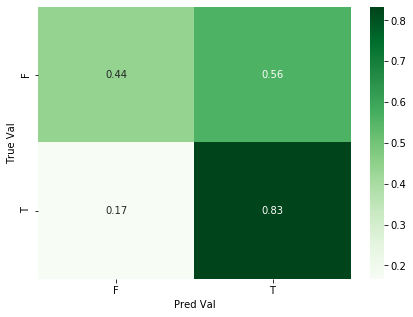

In [356]:
confusion_reporting(y_test, y_pred)

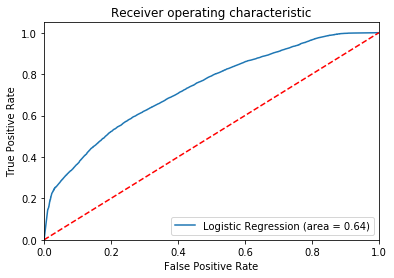

In [357]:
rf_roc_auc = roc_auc_score(y_test, rf_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()